# 多项式插值
顾名思义，即以一个多项式的形式来刻画经过一系列点的曲线。为了更加严谨一些, 这里参考Wiki的定义。
给定一组 $n+1$ 个数据点 $\left(x_{i}, y_{i}\right)$, 其中任意两个 $x_{i}$ 都不相同, 需要找到一个满足 $p\left(x_{i}\right)=y_{i}, i=0,1, \ldots, n$ 的不大于 $n$ 阶的 $p$ 阶多项式。
## 拉格朗日插值（Lagrange Interpolation）
设 $l_{i}(x)$ 是 $n$ 次多项式，且在插值节点 $x_{0}, x_{1}, \ldots, x_{n}$ 上满足：当 $i=k$ 时, $l_{k}\left(x_{i}\right)=1$; 当 $i \neq k$ 时, $l_{k}\left(x_{i}\right)=0$ 。称 $l_{k}(x)$ 为节点 $x_{0}, x_{1}, \ldots, x_{n}$ 上的 $n$ 次Lagrange基函数。由插值基函数可得插值多项式为:
$$
L_{n}(x)=\sum_{k=0}^{n} y_{k} l_{k}(x)=\sum_{k=0}^{n} y_{k} \prod_{i=0, i \neq k}^{n} \frac{x-x_{i}}{x_{k}-x_{i}}
$$
当 $n=1$ 和 2 时，即为线性插多项式和抛物线插值多项式。

## 总结
1. 假设共有n个样本点，分别找到过$(x_i,1)$以及在其它$(x_j,0)$的(n-1)次多项式
2. 将得到的多项式分别乘以$x_i$对应的$y_i$，使其过$(x_i,y_i)$，但在其他的$x_j$点上对应的$y_j$仍然为0
3. 将所有的多项式相加，则会得到一个在所有$x_i$点都会经过对应$y_i$的曲线，也就是需要找的目标插值函数

本质上就是在解方程，用n个确定的点来找到(n-1)次多项式的系数

拉格朗日插值虽然简单易用，但是有个很大的局限，即每增加一个新的插值点时，整个基函数就需要重新构建，这大大增加了运算量。为此，我们需要寻找一种新的基函数，其能够在节点增加时，只需要在原有的基函数上增加一些新的基函数即可，而无需对原始的基函数进行重构

In [31]:
from functools import reduce
import operator
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# mul函数是计算两个参数的乘积。mul (a, b): "Same as a * b."

In [32]:
def lagrange(x_val, y_val, x):
    assert len(x_val) > 1 and (len(x_val) == len(y_val))

    def basis(i):
        l_i = [(x - x_val[j]) / (x_val[i] - x_val[j]) for j in range(len(x_val)) if j != i]
        return reduce(operator.mul, l_i) * y_val[i]

    return sum(basis(i) for i in range(len(x_val)))

## 牛顿插值
设插值节点为 $x_{0}, x_{1}, \ldots, x_{n}$, 考虑函数组
$$
\begin{aligned}
&\phi_{0}(x)=1 \\
&\phi_{1}(x)=x-x_{0} \\
&\phi_{2}(x)=\left(x-x_{0}\right)\left(x-x_{1}\right) \\
&\ldots \cdots \\
&\phi_{n}(x)=\left(x-x_{0}\right)\left(x-x_{1}\right) \ldots\left(x-x_{n-1}\right)
\end{aligned}
$$
其中 $\phi_{k}(x)$ 是 $k$ 次多项式, 且相互之间线性无关, 为此可以使用其构造基函数。该基函数的一个 优点是当增加一个新的插值节点 $x_{n+1}$ 时, 只需在原有基函数的基础上增加一个新的函数 $\phi_{n+1}(x)$ 即可。
$$
\phi_{n+1}(x)=\left(x-x_{0}\right)\left(x-x_{1}\right) \ldots\left(x-x_{n-1}\right)\left(x-x_{n}\right)
$$
则牛顿插值多项式可以表示为：
$$
N(x)=\sum_{k=0}^{n} a_{k} n_{k}(x)=\sum_{k=0}^{n} a_{k} \prod_{i=0}^{k-1}\left(x-x_{i}\right)
$$
其中, $a_{k}=\left[y_{0}, \ldots, y_{k}\right]$ 表示差商, $n_{k}(x)$ 为插值基函数

### 差商
设节点为 $x_{0}, x_{1}, \ldots, x_{n}$ ，则称：
$f\left[x_{i}, x_{j}\right]=\frac{f\left(x_{j}\right)-f\left(x_{i}\right)}{x_{j}-x_{i}}$ 为 $f(x)$ 关于节点 $x_{i}, x_{j}$ 的一阶差商；
$f\left[x_{i}, x_{j}, x_{k}\right]=\frac{f\left[x_{j}, x_{k}\right]-f\left[x_{i}, x_{j}\right]}{x_{k}-x_{i}}$ 为 $f(x)$ 关于节点 $x_{i}, x_{j}, x_{k}$ 的二阶差商；
一般地,
$f\left[x_{0}, x_{1}, \ldots, x_{k}\right]=\frac{f\left[x_{1}, x_{2}, \ldots, x_{k}\right]-f\left[x_{0}, x_{1}, \ldots, x_{k-1}\right]}{x_{k}-x_{0}}$ 为 $f(x)$ 关于节点 $x_{0}, x_{1}, \ldots, x_{k}$ 的 $k$ 阶差商
利用差商的递推定义，我们可以构造差商表来计算差商。
![](note_pic/v2-f60ddc27b3bb08aae8b44c94c93e734e_1440w.jpeg)

In [33]:
def difference_quotient(x_val, y_val):
    assert len(x_val) == len(y_val)
    n = len(x_val)
    p = np.zeros((n, n+1))
    p[:, 0] = x_val
    p[:, 1] = y_val
    for j in range(2, n+1):
        p[j-1: n, j] = (p[j-1: n, j-1] - p[j-2: n-1, j-1]) / (x_val[j-1: n] - x_val[: n+1-j])

    q = np.diag(p, k=1)
    return p, q

def newton(x_val, y_val, x):
    _, q = difference_quotient(x_val, y_val)

    def basis(i):
        if i > 0:
            l_i = [(x - x_val[j]) for j in range(i)]
        else:
            l_i = [1]
        return reduce(operator.mul, l_i) * q[i]
    return sum(basis(i) for i in range(len(x_val)))

In [34]:
"""
@brief:   计算n阶差商 f[x0, x1, x2 ... xn]
@param:   xi   所有插值节点的横坐标集合                                                        o
@param:   fi   所有插值节点的纵坐标集合                                                      /   \
@return:  返回xi的i阶差商(i为xi长度减1)                                                     o     o
@notice:  a. 必须确保xi与fi长度相等                                                        / \   / \
          b. 由于用到了递归，所以留意不要爆栈了.                                             o   o o   o
          c. 递归减递归(每层递归包含两个递归函数), 每层递归次数呈二次幂增长，总次数是一个满二叉树的所有节点数量(所以极易栈溢出)
"""
def get_order_diff_quot(xi = [], fi = []):
    if len(xi) > 2 and len(fi) > 2:
        return (get_order_diff_quot(xi[:len(xi) - 1], fi[:len(fi) - 1]) - get_order_diff_quot(xi[1:len(xi)], fi[1:len(fi)])) / float(xi[0] - xi[-1])
    return (fi[0] - fi[1]) / float(xi[0] - xi[1])

"""
@brief:  获得Wi(x)函数;
         Wi的含义举例 W1 = (x - x0); W2 = (x - x0)(x - x1); W3 = (x - x0)(x - x1)(x - x2)
@param:  i  i阶(i次多项式)
@param:  xi  所有插值节点的横坐标集合
@return: 返回Wi(x)函数
"""
def get_Wi(i = 0, xi = []):
    def Wi(x):
        result = 1.0
        for each in range(i):
            result *= (x - xi[each])
        return result
    return Wi

"""
@brief: 获得牛顿插值函数
@
"""
def get_Newton_inter(xi = [], fi = []):
    def Newton_inter(x):
        result = fi[0]
        for i in range(2, len(xi)):
            result += (get_order_diff_quot(xi[:i], fi[:i]) * get_Wi(i-1, xi)(x))
        return result
    return Newton_inter

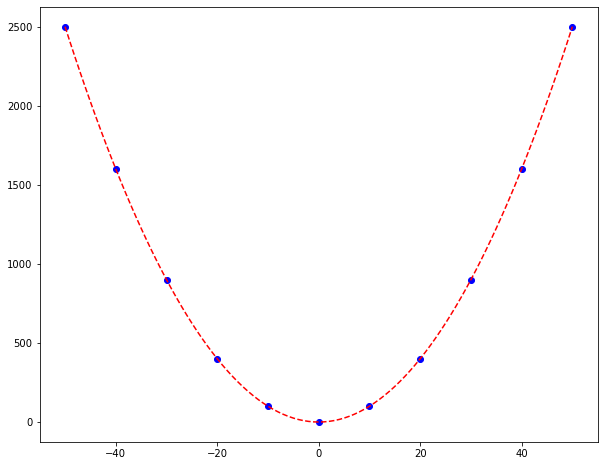

In [35]:
''' 插值节点, 这里用二次函数生成插值节点，每两个节点x轴距离位10 '''
sr_x = [i for i in range(-50, 51, 10)]
sr_fx = [i ** 2 for i in sr_x]

Nx = get_Newton_inter(sr_x, sr_fx)  # 获得插值函数

tmp_x = [i for i in range(-50, 51)]  # 测试用例
tmp_y = [Nx(i) for i in tmp_x]  # 根据插值函数获得测试用例的纵坐标

''' 画图 '''
plt.figure(figsize=(10,8))
ax1 = plt.subplot(111)
plt.sca(ax1)
plt.plot(sr_x, sr_fx, linestyle='', marker='o', color='b')
plt.plot(tmp_x, tmp_y, linestyle='--', color='r')
plt.show()

无论是Lagrange插值还是Newton插值，<mark>本质都是用一个多项式来进可能精确地描绘过节点的原始函数</mark>。但多项式插值的矛盾之处在于，若节点太少，则插值出来的函数与原始函数可能偏离较大，返回的插值结果对于实际的指导用处不大

但若节点太多，则多项式的阶数也会需要相应增加，但太高的阶数容易又会导致绘制出的插值曲线在边缘处不稳定，这便是龙格现象。

## 龙格现象
龙格现象是在一组等间插值点上使用具有高次多项式进行插值时出现的区间边缘处的震荡问题。以函数$f(x) = \frac{1}{1+x^2}$为例，可以发现随着节点个数逐渐增加，插值精度在不断提升，但插值曲线也开始在边缘处变得不够稳定。那是否有什么方法能够做到二者兼顾呢，分段插值应运而生
![](note_pic/v2-d64bf549690dd3ebcb7b5aeafdbc01e6_1440w.jpeg)

In [36]:
original_x = np.arange(-5.0, 5.01, 0.01)
original_y = [0.0] * len(original_x)
for i in range(len(original_y)):
    original_y[i] = 1 / (1 + original_x[i] * original_x[i])

x_arr = np.arange(-5.0, 5.5, 1)
y_arr = [0.0] * len(x_arr)
for i in range(len(x_arr)):
    y_arr[i] = 1 / (1 + x_arr[i] ** 2)

x = np.arange(-5.0, 5.01, 0.01)
y = [0.0] * len(x)
for i in range(len(y)):
    y[i] = lagrange(x_arr, y_arr, x[i])

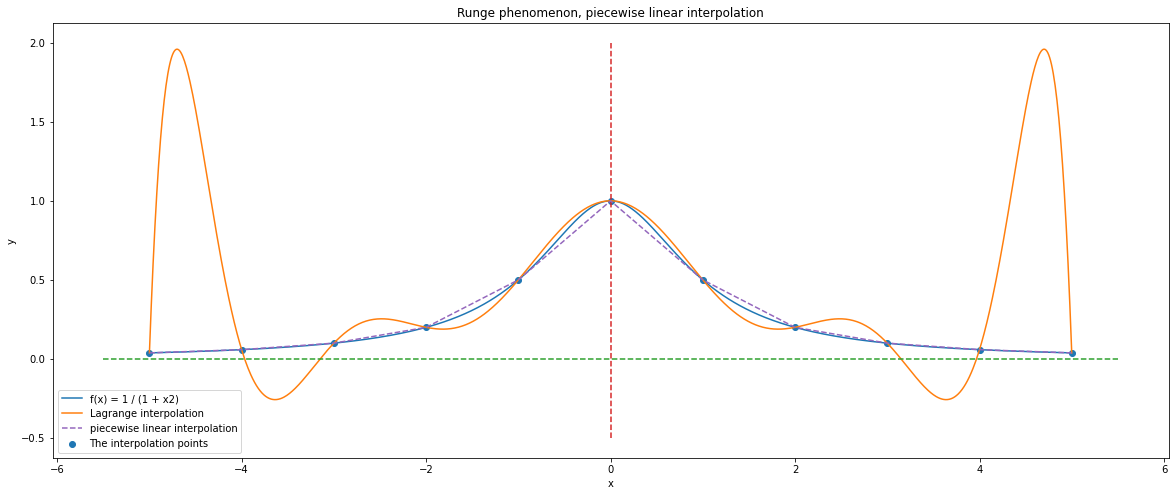

In [37]:
plt.figure(figsize=(20,8))
plt.plot(original_x, original_y, label='f(x) = 1 / (1 + x2)')
plt.scatter(x_arr, y_arr, label='The interpolation points')
plt.plot(x, y, label='Lagrange interpolation')
plt.plot([-5.5, 5.5], [0, 0], linestyle='--')
plt.plot([0, 0], [-0.5, 2], linestyle='--')
plt.plot(x_arr, y_arr, linestyle='--', label='piecewise linear interpolation')

plt.title("Runge phenomenon, piecewise linear interpolation")
plt.legend(loc="lower left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 分段插值
为了避免高次插值多项式的缺陷, 得到 $f(x)$ 较好的近似式，一般采用分段插值法, 即把插值区间 $[a, b]$ 分为若干个子区间, 在每个子区间上构造低次插值多项式.
常见的分段插值主要有分段线性插值, 三次Hermite插值以及三次样条插值。
## 分段线性插值（Piecewise Linear Interpolation）
设 $a \leq x_{0}<x_{1}<\ldots<x_{n} \leq b$ 为 $[a, b]$ 上的互异节点, $f(x)$ 在这些节点上的函数值为 $y_{0}, y_{1}, \ldots, y_{n}$ ，在每个子区间 $\left[x_{k}, x_{k+1}\right]$ 上作线性插值，即取:
$$
f(x) \approx N_{1, k+1}(x)=f\left(x_{k}\right)+f\left[x_{k}, x_{k+1}\right]\left(x_{k+1}-x_{k}\right), x_{k}<x<x_{k+1}
$$
记 $h_{k}=x_{k+1}-x_{k}$, 分段函数 $I_{h}(x)$ 在小区间 $\left[x_{k}, x_{k+1}\right]$ 上可以表示为:
$$
I_{h}(x)=y_{k} \frac{x-x_{k+1}}{x_{k}-x_{k+1}}+y_{k+1} \frac{x-x_{k}}{x_{k+1}-x_{k}}
$$
其中 $x \in\left[x_{k}, x_{k+1}\right], k=0,1, \ldots, n-1$

说白了。就是分段将每两个相邻的节点用直线连起来，如此形成的一条折线就是分段线性插值函数。计算x点的插值时，只用到x左右的两个节点，计算量与节点个数n无关。
假设两个节点为（x1，y1）和（x2，y2），则该区间上的一次线性方程为：
$$
\mathrm{F} 1=\frac{x-x_{2}}{x_{1}-x_{2}} f\left(x_{1}\right)+\frac{x-x_{1}}{x_{2}-x_{1}} f\left(x_{2}\right)
$$

证明过程：
![](note_pic/2019051122082240.png)
$$
\begin{gathered}
y=\frac{y_{2}-y_{1}}{x_{2}-x_{1}}\left(x-x_{1}\right)+y_{1} \\
=\frac{x-x_{1}}{x_{2}-x_{1}} y_{2} - \frac{x-x_{1}}{x_{1}-x_{2}} y_{1}+y_{1} \\
=\frac{x-x_{1}}{x_{2}-x_{1}} y_{2}+\left(1-\frac{x-x_{1}}{x_{1}-x_{2}}\right) y_{1} \\
=\frac{x-x_{2}}{x_{1}-x_{2}} y_{1}+\frac{x-x_{1}}{x_{2}-x_{1}} y_{2}
\end{gathered}
$$

In [38]:
def piecewise_linear_interp(x_val, y_val, x_lst):
    x_lst = [x_lst] if isinstance(x_lst, (float, int)) else x_lst
    x_loc = np.searchsorted(x_val, x_lst)

    res_lst = []
    for x, i in zip(x_lst, x_loc):
        L_i = y_val[i-1] * (x - x_val[i]) / (x_val[i-1] - x_val[i]) + \
              y_val[i] * (x - x_val[i-1]) / (x_val[i] - x_val[i-1])
        res_lst.append(L_i)
    return res_lst

In [39]:
original_x = np.arange(-5.0, 5.01, 0.01)
original_y = [0.0] * len(original_x)
for i in range(len(original_y)):
    original_y[i] =original_x[i] * original_x[i]

x_arr = np.arange(-5.0, 5.5, 1)
y_arr = [0.0] * len(x_arr)
for i in range(len(x_arr)):
    y_arr[i] = x_arr[i]**2

x = np.arange(-5.0, 5.01, 0.01)
y = [0.0] * len(x)
for i in range(len(y)):
    y[i] = piecewise_linear_interp(x_arr, y_arr, x[i])

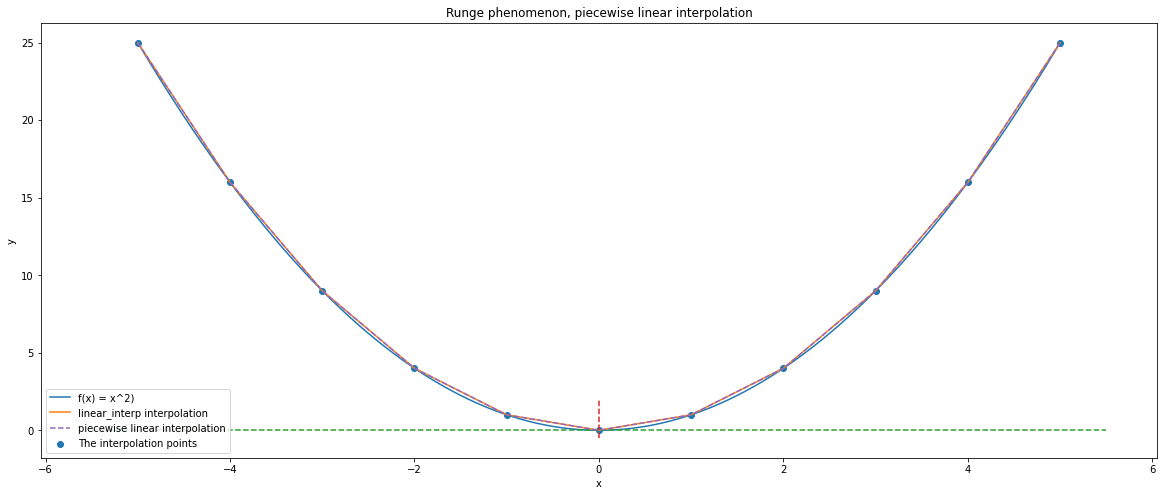

In [40]:
plt.figure(figsize=(20,8))
plt.plot(original_x, original_y, label='f(x) = x^2)')
plt.scatter(x_arr, y_arr, label='The interpolation points')
plt.plot(x, y, label='linear_interp interpolation')
plt.plot([-5.5, 5.5], [0, 0], linestyle='--')
plt.plot([0, 0], [-0.5, 2], linestyle='--')
plt.plot(x_arr, y_arr, linestyle='--', label='piecewise linear interpolation')

plt.title("Runge phenomenon, piecewise linear interpolation")
plt.legend(loc="lower left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

分段线性插值在节点处连续但不可导。

分段低次插值有效地避免了龙格现象, 同时其截断误差也得到了有效的控制, 总体是比较稳定的。但其缺点在于插值条件仅限定函数值在节点处相等，这仅能保证插值函数的连续性, 总体的光滑性不高，若需要得到光滑性更好的插值函数, 我们需要对函数的导数进行约束。

## 三次Hermite插值（Cubic Hermite Interpolation）
已知函数 $y=f(x)$ 在节点 $x_{0}, x_{1}$ 上的函数值 $f\left(x_{i}\right)=y_{i}$ 和导数值 $f^{\prime}\left(x_{i}\right)=m_{i}, i=0,1$, 为了表示该函数, 可在子区间 $\left[x_{0}, x_{1}\right]$ 上构造三次揷值多项式 $H_{3}(x)$, 使其满足 $H_{3, i}\left(x_{i}\right)=y_{i}, H_{3, i}^{\prime}\left(x_{i}\right)=m_{i}(i=0,1, \ldots, n)$ 。
根据Lagrange方法的思想，我们可以采用基函数的方法来构造揷值多项式 $H_{3, i}(x)$, 其可表示 为:
$H_{3, i}(x)=y_{i} \alpha_{i}(x)+y_{j} \alpha_{j}(x)+m_{i} \beta_{i}(x)+m_{j} \beta_{j}(x)$
其中, $\alpha_{i}(x), \alpha_{j}(x), \beta_{i}(x), \beta_{j}(x)$ 为揷值基函数，均为次数不超过 3 的多项式, 且满足 $\alpha_{j}\left(x_{i}\right)=\delta_{j i}, \alpha_{j}^{\prime}\left(x_{i}\right)=0$
$$
\beta_{j}\left(x_{i}\right)=0, \beta_{j}^{\prime}\left(x_{i}\right)=\delta_{j i}
$$
其中 $i, j=0,1$ 。
根据约束条件通过待定系数法可得（具体证明步骤略）：
$$
\begin{aligned}
&H_{3, i}(x)=\left(1+2 \frac{x-x_{i-1}}{h_{i}}\right)\left(\frac{x-x_{i}}{h_{i}}\right)^{2} y_{i-1}+\left(1+2 \frac{x_{i}-x}{h_{i}}\right)\left(\frac{x-x_{i-1}}{h_{i}}\right)^{2} y_{i} \\
&+\left(x-x_{i-1}\right)\left(\frac{x-x_{i}}{h_{i}}\right)^{2} m_{i-1}+\left(x-x_{i}\right)\left(\frac{x-x_{i-1}}{h_{i}}\right)^{2} m_{i}
\end{aligned}
$$

其中，$h_i = x_i$

In [41]:
def cubic_hermite_interp(x_val, y_val, x_deriv, x_interp):
    x_lst = [x_interp] if isinstance(x_interp, (float, int)) else x_interp
    x_loc = np.searchsorted(x_val, x_lst)

    res_lst = []
    for x, i in zip(x_lst, x_loc):
        h_i = x_val[i] - x_val[i-1]
        H_i = (1 + 2 * (x - x_val[i-1]) / h_i) * ((x - x_val[i]) / h_i) ** 2 * y_val[i-1] + \
              (1 + 2 * (x_val[i] - x) / h_i) * ((x - x_val[i-1]) / h_i) ** 2 * y_val[i] + \
              (x - x_val[i-1]) * ((x - x_val[i]) / h_i) ** 2 * x_deriv[i-1] + \
              (x - x_val[i]) * ((x - x_val[i-1]) / h_i) ** 2 * x_deriv[i]

        res_lst.append(H_i)

    return res_lst

但这里需要指出的是，在大部分情况下，我们是无法知道节点处的一阶导数的，所以上面的插值函数实用性并不强。那有没有什么办法来确定一阶导数呢，答案当然是有的，具体逻辑大家可以参考[Monotone Piecewise Cubic Interpolation](http://www.ams.sunysb.edu/~jiao/teaching/ams527_spring14/lectures/SNA000238.pdf)，并试着自己实现一下

## 三次样条插值
设在区间 $[a, b]$ 上给定 $n+1$ 个节点 $x_{i}\left(a \leq x_{0} \leq \ldots \leq x_{n} \leq b\right)$, 在节点 $x_{i}$ 处的函数值为 $y_{i}=f\left(x_{i}\right), i=0,1, \ldots, n$ 。若函数 $S(x)$ 满足以下条件:
1）在每个子区间 $\left[x_{i-1}, x_{i}\right],(i=1,2, \ldots, n)$ 上 $S(x)$ 是三次多项式
2) $S\left(x_{i}\right)=y_{i}, i=0,1, \ldots, n$
3) 在区间 $[a, b]$ 上 $S(x)$ 的二阶导数 $S^{\prime \prime}(x)$ 连续
则称 $S(x)$ 为函数 $y=f(x)$ 在区间 $[a, b]$ 上的三次样条揷值函数。
根据定义, 可知揷值条件为：
-揷值特性： $S\left(x_{i}\right)=f\left(x_{i}\right)$
- 相互连接: $S_{i-1}\left(x_{i}\right)=S_{i}\left(x_{i}\right)$
- 一阶导连续: $S_{i-1}^{\prime}\left(x_{i}\right)=S_{i}^{\prime}\left(x_{i}\right)$
- 二阶导连续: $S_{i-1}^{\prime \prime}\left(x_{i}\right)=S_{i}^{\prime \prime}\left(x_{i}\right)$
由于 $S(x)$ 是分段三次多项式, 故在每个子区间 $\left[x_{i-1}, x_{i}\right], i=1,2, \ldots, n$ 上, $S(x)$ 有4个待 定参数; 由于共有 $n$ 个子区间, 所以 $S(x)$ 共有 $4 n$ 个待定参数。根据定义中的条件(3)可知共有 $3(n-1)$ 个条件, 加上定义中的条件(2)的 $n+1$ 个条件, 共有 $4 n-2$ 个条件。但有 $4 n$ 个待 定参数, 所以还需增加两个条件才能确定最终的 $S(x)$ 。
由于 $S(x)$ 是分段三次多项式，故在每个子区间 $\left[x_{i-1}, x_{i}\right], i=1,2, \ldots, n$ 上, $S(x)$ 有4个待 定参数; 由于共有 $n$ 个子区间, 所以 $S(x)$ 共有 $4 n$ 个待定参数。根据定义中的条件(3)可知共有 $3(n-1)$ 个条件, 加上定义中的条件(2)的 $n+1$ 个条件, 共有 $4 n-2$ 个条件。但有 $4 n$ 个待 定参数, 所以还需增加两个条件才能确定最终的 $S(x)$ 。
根据最终两个条件选择的不同，可以分为不同的样条函数。
- 若设定两端节点处的二阶导数值为 0 , 即 $S^{\prime \prime}\left(x_{0}\right)=S^{\prime \prime}\left(x_{n}\right)=0$, 则得到三次自然样条 (Natural Spline)
- 若指定两端节点处的一阶导数值, 即 $S^{\prime}\left(x_{0}\right)=\mu, S^{\prime}\left(x_{n}\right)=v$, 则得到三次钳制样条 (Clamped Spline)
- 若设定两端节点处的函数值、一阶导、二阶导皆相等, 即 $S\left(x_{0}\right)=S\left(x_{n}\right), S^{\prime}\left(x_{0}\right)=S^{\prime}\left(x_{n}\right), S^{\prime \prime}\left(x_{0}\right)=S^{\prime \prime}\left(x_{n}\right)$, 则得到三次周期样条 (Periodic Spline)
联立约束条件通过待定系数法可得：
$$
\begin{aligned}
&S_{i}(x)=M_{i-1} \frac{\left(x_{i}-x\right)^{3}}{6 h_{i}}+M_{i} \frac{\left(x-x_{i-1}\right)^{3}}{6 h_{i}}+\left(y_{i-1}-\frac{M_{i-1} h_{i}^{2}}{6}\right) \frac{x_{i}-x}{h_{i}}+\left(y_{i}-\frac{M_{i} h_{i}^{2}}{6}\right) \frac{x-x_{i-1}}{h_{i}}, x \\
&\in\left[x_{i-1}, x_{i}\right]
\end{aligned}
$$
其中，$M_{i}=S^{\prime \prime}\left(x_{i}\right), i=0,1, \ldots, n$, 是 $S(x)$ 在节点 $x_{i}$ 处的二阶导数值, $h_{i}=x_{i}-x_{i-1}$
$$
\begin{aligned}
&u_{i}=\frac{h_{i}}{h_{i}+h_{i+1}}, \lambda_{i}=\frac{h_{i+1}}{h_{i}+h_{i+1}}=1-u_{i} \\
&d_{i}=\frac{6}{h_{i}+h_{i+1}}\left[\frac{y_{i+1}-y_{i}}{h_{i+1}}-\frac{y_{i}-y_{i-1}}{h_{i}}\right]=6 f\left[x_{i-1}, x_{i}, x_{i+1}\right]
\end{aligned}
$$
以三次自然样条为例, 已知 $M_{0}=M_{n}=0$, 则末知量减少了两个, 相当于 $n-1$ 个等式求解 $n-1$ 个变量, 且系数矩阵严格对角占优, 矩阵可逆, 方程组存在唯一解, 所以可以快速得到 $M_{1}, M_{2}, \ldots, M_{n-1}$
$$
\left(\begin{array}{ccccc}
2 & \lambda_{1} & & & \\
\mu_{2} & 2 & \lambda_{2} & & \\
& \ddots & \ddots & \ddots & \\
& & \mu_{n-2} & 2 & \lambda_{n-2} \\
& & & \mu_{n-1} & 2
\end{array}\right)\left(\begin{array}{c}
M_{1} \\
M_{2} \\
\vdots \\
M_{n-2} \\
M_{n-1}
\end{array}\right)=\left(\begin{array}{c}
d_{1} \\
d_{2} \\
\vdots \\
d_{n-2} \\
d_{n-1}
\end{array}\right)
$$
初看起来, 可能过程有点绕, 这里我根据自己的理解简单总结一下。由于 $S(x)$ 是分段三次多项 式, 所以其二阶导数形式 $S^{\prime \prime}(x)$ 在各子区间内是关于节点二阶导数 $M_{i-1}, M_{i}$ 的线性函数。根据 前文所述的分段线性函数的表现形式, 可以通过对 $S^{\prime \prime}(x)$ 积分将 $S(x)$ 的表现形式求解出来, 求 解后发现 $S(x)$ 是关于节点二阶导数 $M_{i}$ 的多项式。再基于节点处的约束条件, 来生成求解节点处 二阶导数 $M_{i}$ 的矩阵。求出 $M_{i}$ 后将其带入 $S_{i}(x)$ 的表达式, 即可得到子区间 $\left[x_{i-1}, x_{i}\right]$ 最终的分段多项式

In [42]:
def cubic_spline_interp(x_val, y_val, x_interp):
    x_lst = [x_interp] if isinstance(x_interp, (float, int)) else x_interp
    x_loc = np.searchsorted(x_val, x_lst)

    p, q = difference_quotient(x_val, y_val)

    n = len(x_val) - 1
    h_vec = x_val[1:] - x_val[:-1]
    _u_vec = h_vec[-1:] / (h_vec[:-1] + h_vec[1:])
    u_vec = _u_vec[1:]
    lam_vec = 1 - u_vec

    diag_mat = np.diag(u_vec, k=-1) + np.diag([2] * (n-1)) + np.diag(lam_vec, k=1)
    d_vec = 6 * p[2:, 3]
    m_vec = np.insert(np.append(np.linalg.solve(diag_mat, d_vec), 0), 0, 0)

    res_lst = []
    for x, i in zip(x_lst, x_loc):
        h_i = x_val[i] - x_val[i-1]
        S_i = m_vec[i-1] * (x_val[i] - x) ** 3 / (6 * h_i) + m_vec[i] * (x - x_val[i-1]) ** 3 / (6 * h_i) + \
              (y_val[i-1] - 1/6 * m_vec[i-1] * h_i ** 2) * (x_val[i] - x) / h_i + \
              (y_val[i] - 1/6 * m_vec[i] * h_i ** 2) * (x - x_val[i-1]) / h_i
        res_lst.append(S_i)

    return res_lst

In [43]:
original_x = np.arange(-5.0, 5.01, 0.01)
original_y = [0.0] * len(original_x)
for i in range(len(original_y)):
    original_y[i] = 1 / (1 + original_x[i] * original_x[i])

x_arr = np.arange(-5.0, 5.5, 1)
y_arr = [0.0] * len(x_arr)
for i in range(len(x_arr)):
    y_arr[i] = 1 / (1 + x_arr[i] ** 2)

x = np.arange(-5.0, 5.01, 0.01)
y = [0.0] * len(x)
for i in range(len(y)):
    y[i] = cubic_spline_interp(x_arr, y_arr, x[i])

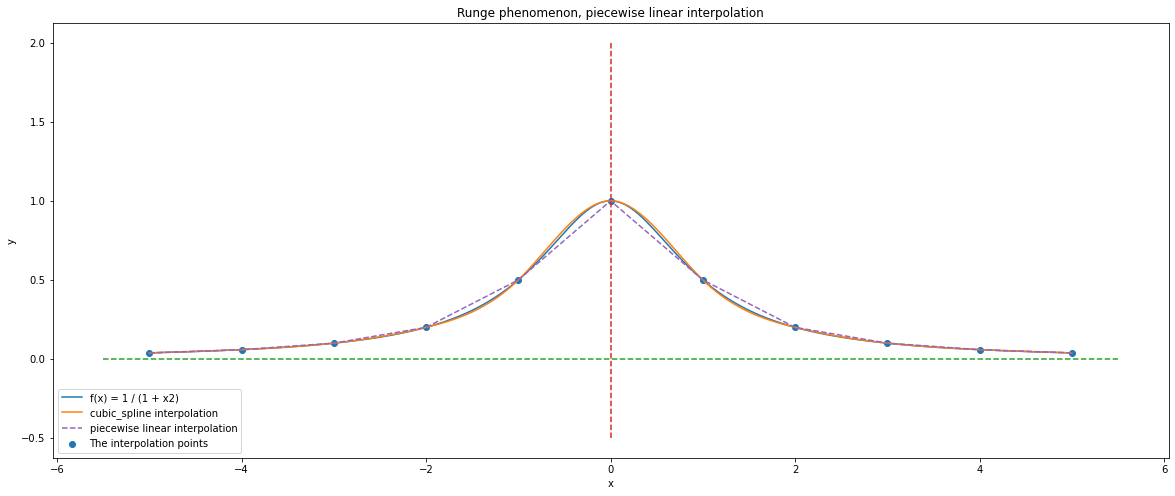

In [44]:
plt.figure(figsize=(20,8))
plt.plot(original_x, original_y, label='f(x) = 1 / (1 + x2)')
plt.scatter(x_arr, y_arr, label='The interpolation points')
plt.plot(x, y, label='cubic_spline interpolation')
plt.plot([-5.5, 5.5], [0, 0], linestyle='--')
plt.plot([0, 0], [-0.5, 2], linestyle='--')
plt.plot(x_arr, y_arr, linestyle='--', label='piecewise linear interpolation')

plt.title("Runge phenomenon, piecewise linear interpolation")
plt.legend(loc="lower left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()